#  Performance Analysis for TensorFlow Profiling Result
This notebook guides auidences how to generate trace.json file by using TensorFlow Profiler, and then analyze it accordingly.

## Enable TensorFlow Profiler
***
This section shows users how to enable TensorFlow Profiler for both Training and Infernce

### Prerequisites

Check the TensorFlow version used in the notebook

In [20]:
import warnings
warnings.filterwarnings('ignore')
%run -i "../../version_check.py"

TensorTlow version:  2.10.0
MKL enabled : False
itex_version :  1.1.0
scikit learn Version:  1.6.1
neural_compressor version 3.3.1
Arch :  SPR


After TensorFlow 2.11, TensorFlow only generate a xplane.pb file and doesn't have trace.json file as output. 
This notebook could only support TensorFlow version 2.10 and prior.

In [21]:
import tensorflow as tf
major_version = int(tf.__version__.split(".")[0])
minor_version = int(tf.__version__.split(".")[1])
if major_version >= 2 and minor_version > 10:
    print(f"This notebook only support TensorFlow version 2.10 and prior. Detected version is {major_version}.{minor_version}")

### Enable TensorFlow Profiler in the word embeddings workload from Keras-IO

Get the pretrained word embeddedings workload from Keras IO (using specific commit version of the file).

In [22]:
!wget https://raw.githubusercontent.com/keras-team/keras-io/3aca0563e5cebb3e442bee3f7c30adc53cfe3102/examples/nlp/pretrained_word_embeddings.py

--2025-04-04 14:03:08--  https://raw.githubusercontent.com/keras-team/keras-io/3aca0563e5cebb3e442bee3f7c30adc53cfe3102/examples/nlp/pretrained_word_embeddings.py


Resolving proxy-dmz.intel.com (proxy-dmz.intel.com)... 10.7.211.16
Connecting to proxy-dmz.intel.com (proxy-dmz.intel.com)|10.7.211.16|:912... connected.
Proxy request sent, awaiting response... 200 OK
Length: 8490 (8.3K) [text/plain]
Saving to: ‘pretrained_word_embeddings.py’

pretrained_word_emb 100%[===================>]   8.29K  --.-KB/s    in 0s      

2025-04-04 14:03:08 (44.8 MB/s) - ‘pretrained_word_embeddings.py’ saved [8490/8490]



Enable TensorFlow Profiler for both Training and Inference sessions in the word embeddings workloads.  
You could see the changes in profile.patch for both training session around line 280 and infernece session around line 297.  
We use tf.keras.callbacks.TensorBoard for training session and tf.profiler.experimental.ProfilerOptions for infernece session.  

In [23]:
import IPython
IPython.display.Code(filename="patch/profile.patch")

--- pretrained_word_embeddings.py	2023-03-18 05:25:00.115795211 +0800
+++ pretrained_word_embeddings_new.py	2023-03-18 05:30:50.295782459 +0800
@@ -280,7 +280,8 @@
 model.compile(
     loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
 )
-model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))
+tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logdir-train", profile_batch=(10,20))
+model.fit(x_train, y_train, batch_size=128, epochs=2, validation_data=(x_val, y_val), callbacks=[tensorboard_callback])
 
 """
 ## Export an end-to-end model
@@ -297,8 +298,13 @@
 preds = model(x)
 end_to_end_model = keras.Model(string_input, preds)
 
+options = tf.profiler.experimental.ProfilerOptions(host_tracer_level = 3,
+                                                       python_tracer_level = 1,
+                                                       device_tracer_level = 1)
+tf.profiler.experimental.start('./logdir-inf', options = options)
 probabilities = end_to_end_model.predict(
     [["this message is about computer graphics and 3D modeling"]]
 )
+tf.profiler.experimental.stop()
 
 class_names[np.argmax(probabilities[0])]

Patch the pretrained_word_embeddings and enable TF Profiler.

In [24]:
!patch < patch/profile.patch

patching file pretrained_word_embeddings.py


### Run the word embeddings workload with TensorFlow Profiler

Download the glove dataset for the word embeddings workload

In [ ]:
!mkdir -p ~/.keras/datasets/; wget -P ~/.keras/datasets/ http://nlp.stanford.edu/data/glove.6B.zip; unzip -q ~/.keras/datasets/glove.6B.zip -d ~/.keras/datasets/

--2025-04-04 14:03:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving proxy-dmz.intel.com (proxy-dmz.intel.com)... 10.7.211.16
Connecting to proxy-dmz.intel.com (proxy-dmz.intel.com)|10.7.211.16|:911... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-04 14:03:35--  https://nlp.stanford.edu/data/glove.6B.zip


Connecting to proxy-dmz.intel.com (proxy-dmz.intel.com)|10.7.211.16|:912... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-04 14:03:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Connecting to proxy-dmz.intel.com (proxy-dmz.intel.com)|10.7.211.16|:912... connected.
Proxy request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/home/kevinmj/.keras/datasets/glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2025-04-04 14:06:15 (5.17 MB/s) - ‘/home/kevinmj/.keras/datasets/glove.6B.zip’ saved [862182613/862182613]



Run the word embeddings for both training and inference.  
You will have logdir-train folder with profiling result for training, and logdir-inf folder with profiling result for inference. 

In [26]:
import warnings
warnings.filterwarnings('ignore')
%run -i "pretrained_word_embeddings.py"

17329808/17329808 [==============================] - 12s 1us/step
Number of directories: 20
Directory names: ['talk.politics.mideast', 'misc.forsale', 'sci.med', 'alt.atheism', 'rec.autos', 'comp.os.ms-windows.misc', 'talk.religion.misc', 'sci.space', 'comp.sys.ibm.pc.hardware', 'rec.sport.hockey', 'rec.sport.baseball', 'sci.crypt', 'talk.politics.misc', 'rec.motorcycles', 'comp.sys.mac.hardware', 'sci.electronics', 'talk.politics.guns', 'comp.graphics', 'comp.windows.x', 'soc.religion.christian']
Number of files in comp.graphics: 1000
Some example filenames: ['38785', '39048', '39630', '38835', '38747']
Newsgroups: comp.graphics
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!dog.ee.lbl.gov!network.ucsd.edu!usc!rpi!nason110.its.rpi.edu!mabusj
From: mabusj@nason110.its.rpi.edu (Jasen M. Mabus)
Subject: Looking for Brain in CAD
Message-ID: <c285m+p@rpi.edu>
Nntp-Posting-Host: nason110.its.rpi.edu
Reply-To: mabusj@rpi.edu
Organization: Renss

2025-04-04 14:07:03.811146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


Found 400000 word vectors.
Converted 18012 words (1988 misses)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0      

2025-04-04 14:07:15.702618: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2025-04-04 14:07:15.702650: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2025-04-04 14:07:15.702896: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


Epoch 1/2


2025-04-04 14:07:16.558031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:16.573420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:16.589111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:16.884443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


 18/125 [===>..........................] - ETA: 1s - loss: 3.0228 - acc: 0.0490

2025-04-04 14:07:17.315770: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2025-04-04 14:07:17.315811: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 24/125 [====>.........................] - ETA: 2s - loss: 3.0071 - acc: 0.0540

2025-04-04 14:07:17.532742: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2025-04-04 14:07:17.551763: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2025-04-04 14:07:17.569009: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logdir-train/plugins/profile/2025_04_04_14_07_17

2025-04-04 14:07:17.583045: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logdir-train/plugins/profile/2025_04_04_14_07_17/f0b2b90049c2.jf.intel.com.trace.json.gz
2025-04-04 14:07:17.621540: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logdir-train/plugins/profile/2025_04_04_14_07_17

2025-04-04 14:07:17.629166: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logdir-train/plugins/profile/2025_04_04_14_07_17/f0b2b90049c2.jf.intel.com.memory_pro

121/125 [============================>.] - ETA: 0s - loss: 2.6825 - acc: 0.1346

2025-04-04 14:07:18.778005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:18.803835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:18.834271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:18.935719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


125/125 [==============================] - 3s 16ms/step - loss: 2.6681 - acc: 0.1373 - val_loss: 2.0465 - val_acc: 0.2953
Epoch 2/2
124/125 [============================>.] - ETA: 0s - loss: 1.9278 - acc: 0.3377

2025-04-04 14:07:20.542074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:20.566254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:20.595698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


125/125 [==============================] - 2s 13ms/step - loss: 1.9264 - acc: 0.3385 - val_loss: 1.6896 - val_acc: 0.4024


2025-04-04 14:07:22.252751: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2025-04-04 14:07:22.252771: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2025-04-04 14:07:22.285842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:22.299788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:22.315029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:22.334393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:22.348088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 248ms/step


2025-04-04 14:07:22.464945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2025-04-04 14:07:22.541396: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2025-04-04 14:07:22.675376: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2025-04-04 14:07:22.815344: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logdir-inf/plugins/profile/2025_04_04_14_07_22

2025-04-04 14:07:22.997526: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logdir-inf/plugins/profile/2025_04_04_14_07_22/f0b2b90049c2.jf.intel.com.trace.json.gz
2025-04-04 14:07:23.029319: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logdir-inf/plugins/profile/2025_04_04_14_07_22

2025-04-04 14:07:23.029556: I tensorflow/core/profiler/rpc/client/save_profile.c

Please change below Profile_Dir path for the latest inference result folder in your environment.

In [28]:
import os
import glob

# Define the static part of the path
static_path = "logdir-inf/plugins/profile/"

# Use glob to find directories matching the pattern
matching_paths = glob.glob(os.path.join(static_path, "*"))

# Sort the paths to find the most recent one
latest_path = max(matching_paths, key=os.path.getmtime)

# Set the environment variable using the %env magic command
%env Profile_Dir=$latest_path

env: Profile_Dir=logdir-inf/plugins/profile/2025_04_04_14_07_22


In [29]:
import os
pdir = os.environ.get("Profile_Dir")
os.listdir(pdir)

['f0b2b90049c2.jf.intel.com.trace.json.gz',
 'f0b2b90049c2.jf.intel.com.kernel_stats.pb',
 'f0b2b90049c2.jf.intel.com.overview_page.pb',
 'f0b2b90049c2.jf.intel.com.input_pipeline.pb',
 'f0b2b90049c2.jf.intel.com.memory_profile.json.gz',
 'f0b2b90049c2.jf.intel.com.xplane.pb',
 'f0b2b90049c2.jf.intel.com.tensorflow_stats.pb']

Please also change the below json_path for the trace.json.gz file in the latest inference result folder.  
We will analyze the trace.json file in the following session.

In [ ]:
import os
import glob

# Retrieve the existing Profile_Dir environment variable
profile_dir = os.getenv('Profile_Dir')

# Search for the file matching the pattern within the Profile_Dir
matching_files = glob.glob(os.path.join(profile_dir, "*.trace.json.gz"))

# Since it's guaranteed there will be only one file, retrieve it
if matching_files:
    json_file = matching_files[0]
    # Set the environment variable using the %env magic command
    %env json_path=$json_file
else:
    raise FileNotFoundError("No file matching the pattern '*.trace.json.gz' found in the directory.")

env: json_path=logdir-inf/plugins/profile/2025_04_04_14_07_22/f0b2b90049c2.jf.intel.com.trace.json.gz


## Analyze TensorFlow Profiling Result
***
This section shows users how to analyze TensorFlow Profiling results with a analyze script and its HTML output file.

Analyze the json file from previous session by using Analyze/analyze script.

In [44]:
!Analyze/analyze $json_path

['Analyze/analyze', 'logdir-inf/plugins/profile/2025_04_04_14_07_22/f0b2b90049c2.jf.intel.com.trace.json.gz']
f0b2b90049c2.jf.intel.com.trace.json_tf_op_duration_bar.png
f0b2b90049c2.jf.intel.com.trace.json_tf_op_duration_pie.png


Show all the report folders in order to get the full name of the latest analyze report folder.  
The current timestamp will be added as a postfix of the report folder name. 

In [45]:
import glob
import os
folder_dir = ""

def find_and_assign_report_folder(pattern="report_*"):
    global folder_dir

    # Use glob to find directories matching the pattern
    matching_dirs = glob.glob(pattern)

    # Since it's assumed there will be only one directory matching the pattern, retrieve it
    if matching_dirs:
        folder_dir = matching_dirs[0]
    else:
        raise FileNotFoundError("No directory matching the pattern 'report_*' found.")

    # Print or use the folder_dir variable as needed
    print(folder_dir)
find_and_assign_report_folder()

report_2025-04-04_14-26


Please change folder_dir and put the report folder that you want to analyze.  
Overall, you should pick the latest report folder.  

In [46]:
folder_dir=folder_dir+"/"

There are report.html file which shows all the analysis diagrams.  
We show all the analysis diagrams below, and your could refer to Analyze/README.md file for more details of those analysis diagrams. 

f0b2b90049c2.jf.intel.com.trace.json_tf_op_duration_pie.png


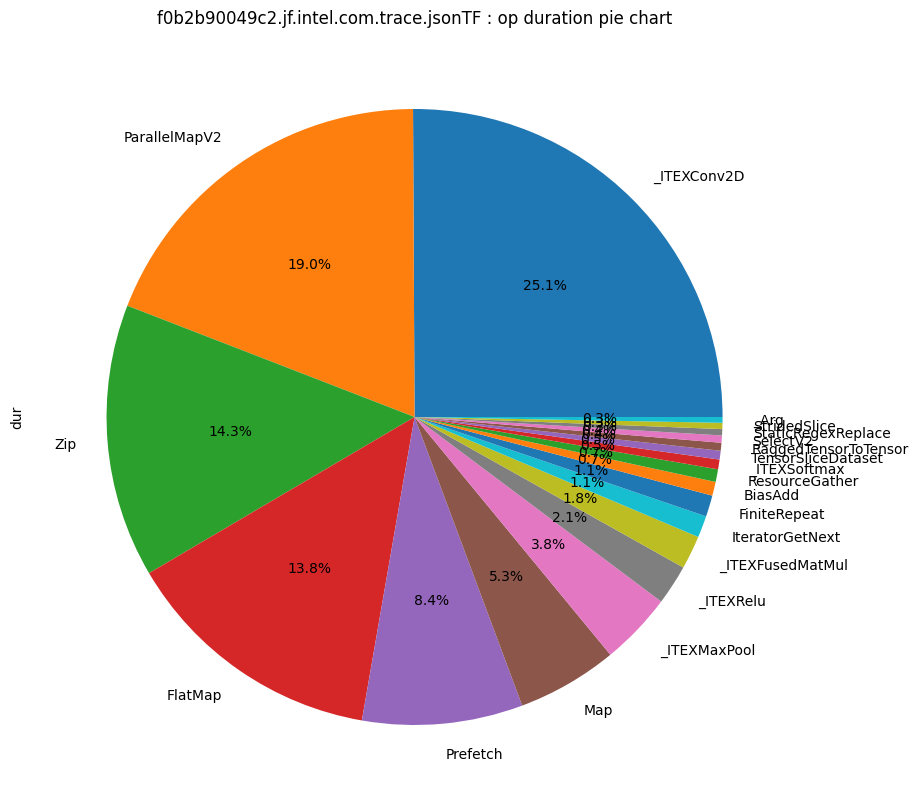

tf_ops_dataframe.png


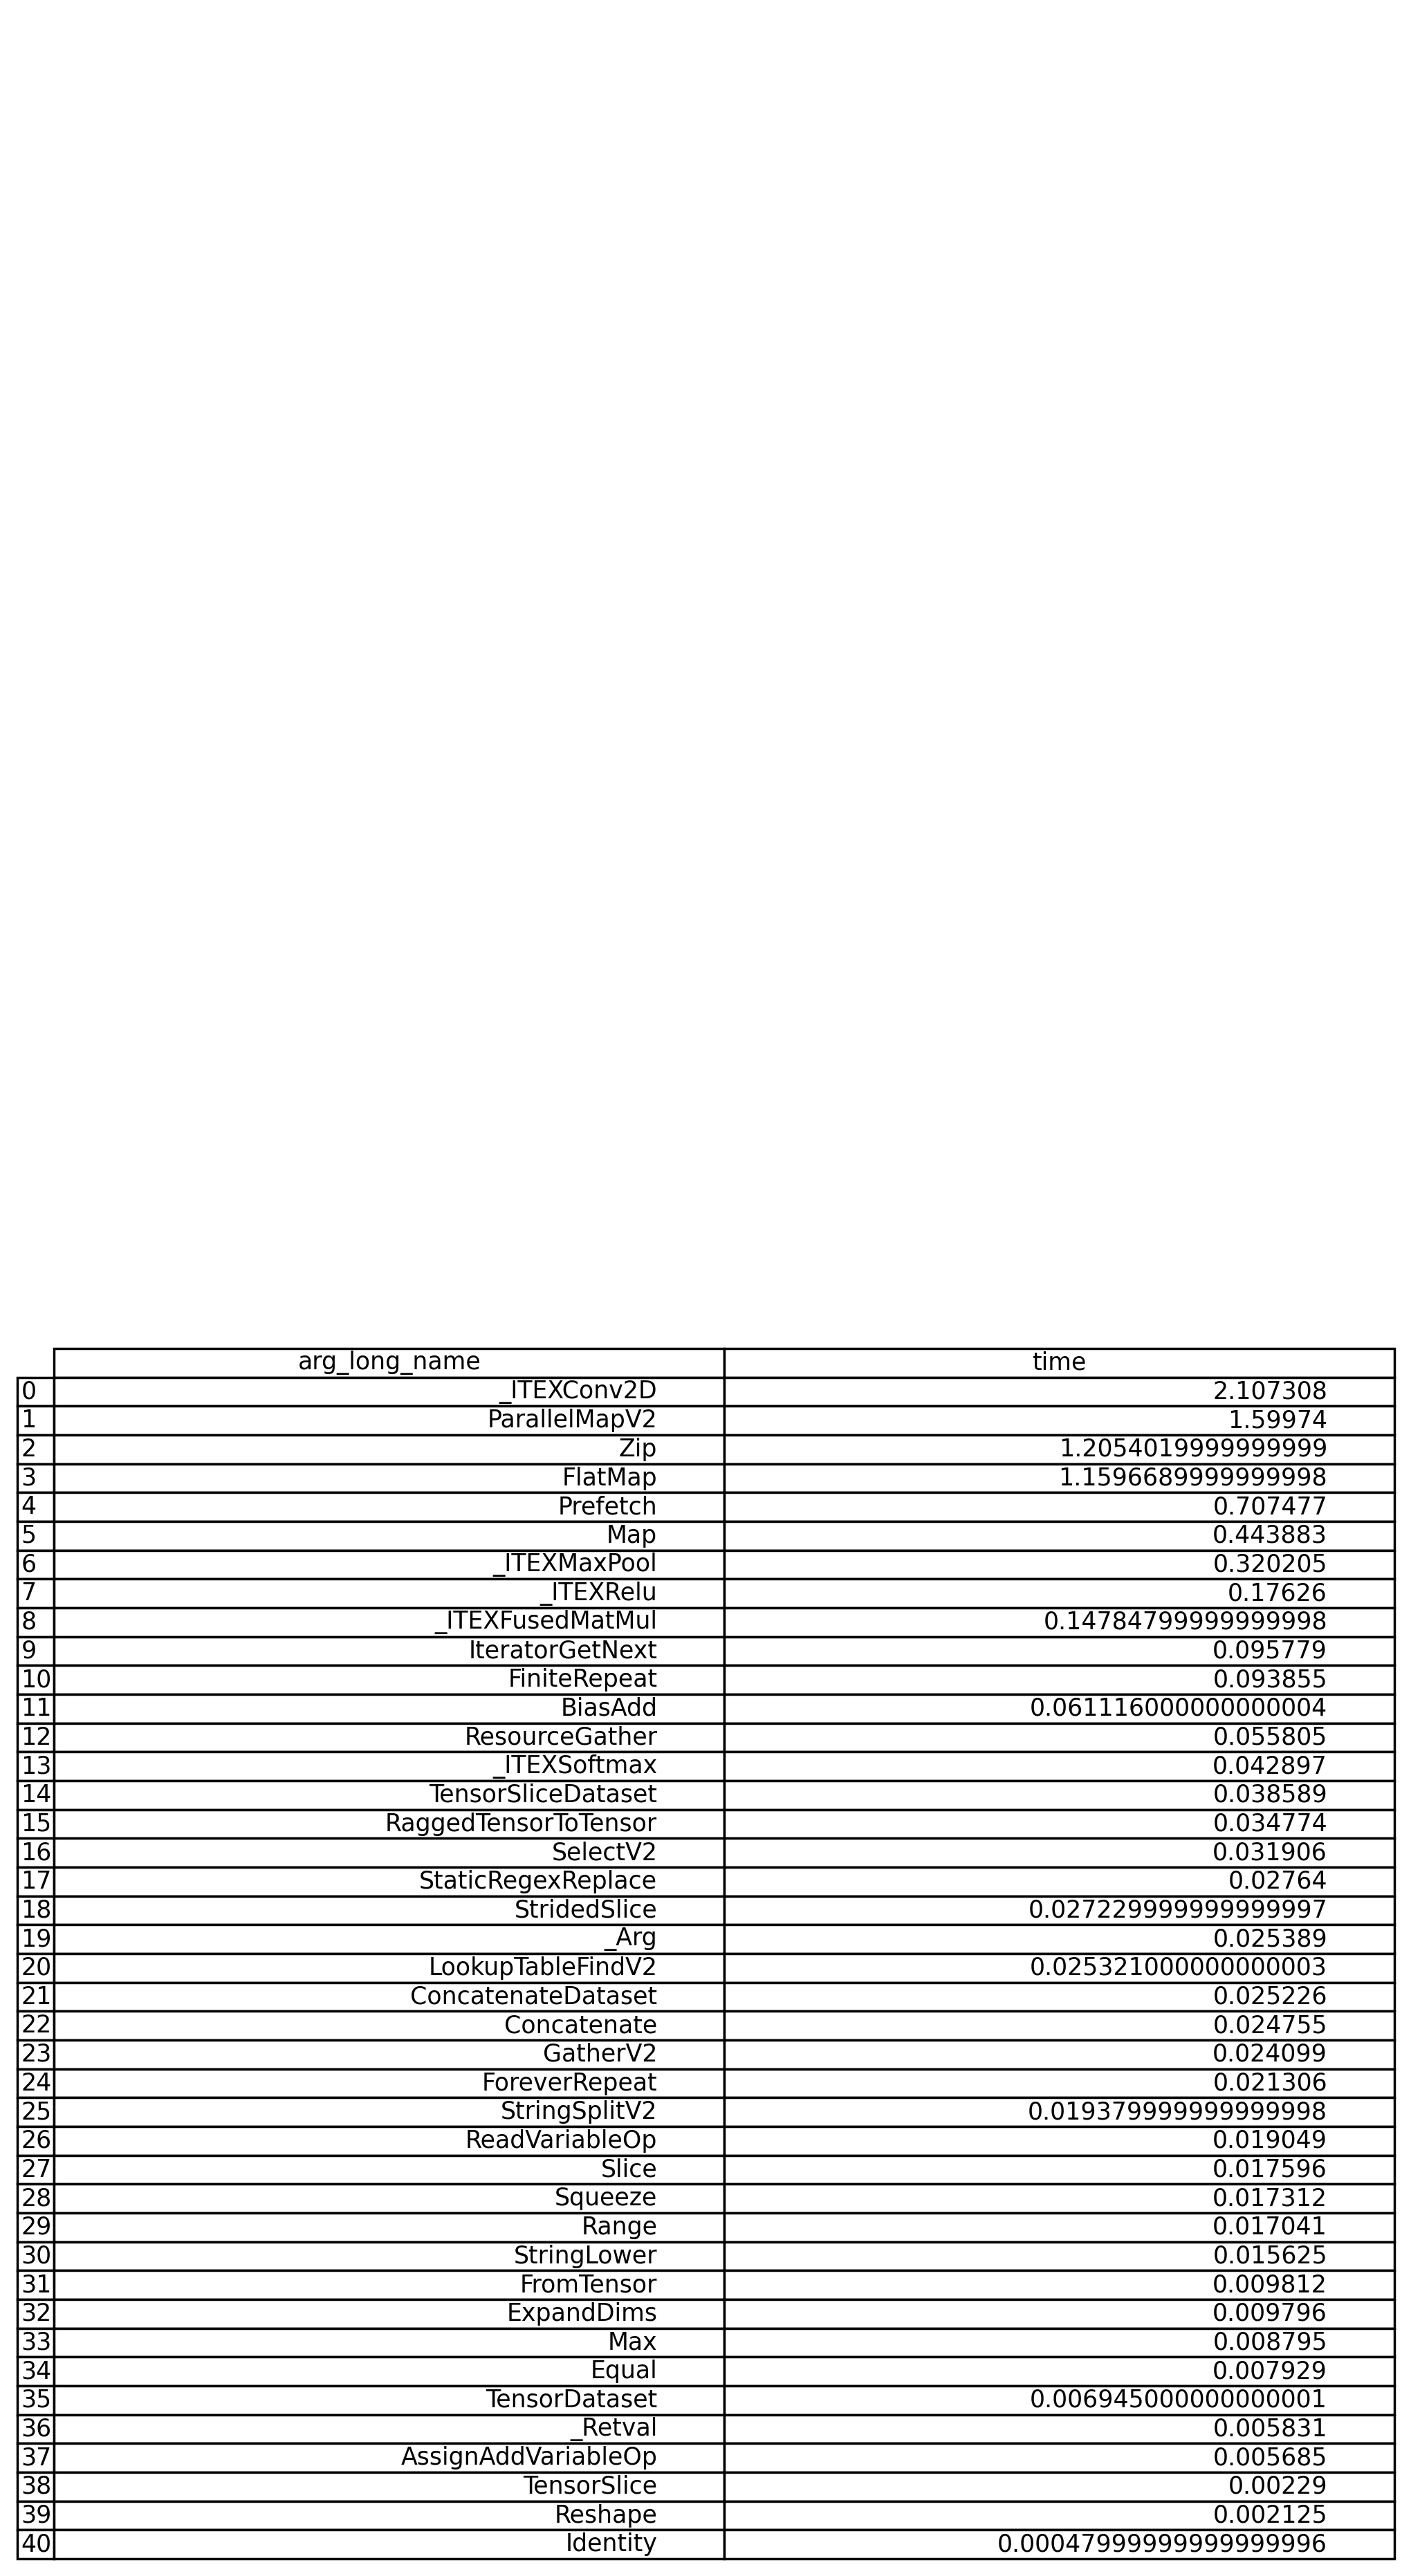

f0b2b90049c2.jf.intel.com.trace.json_tf_op_duration_bar.png


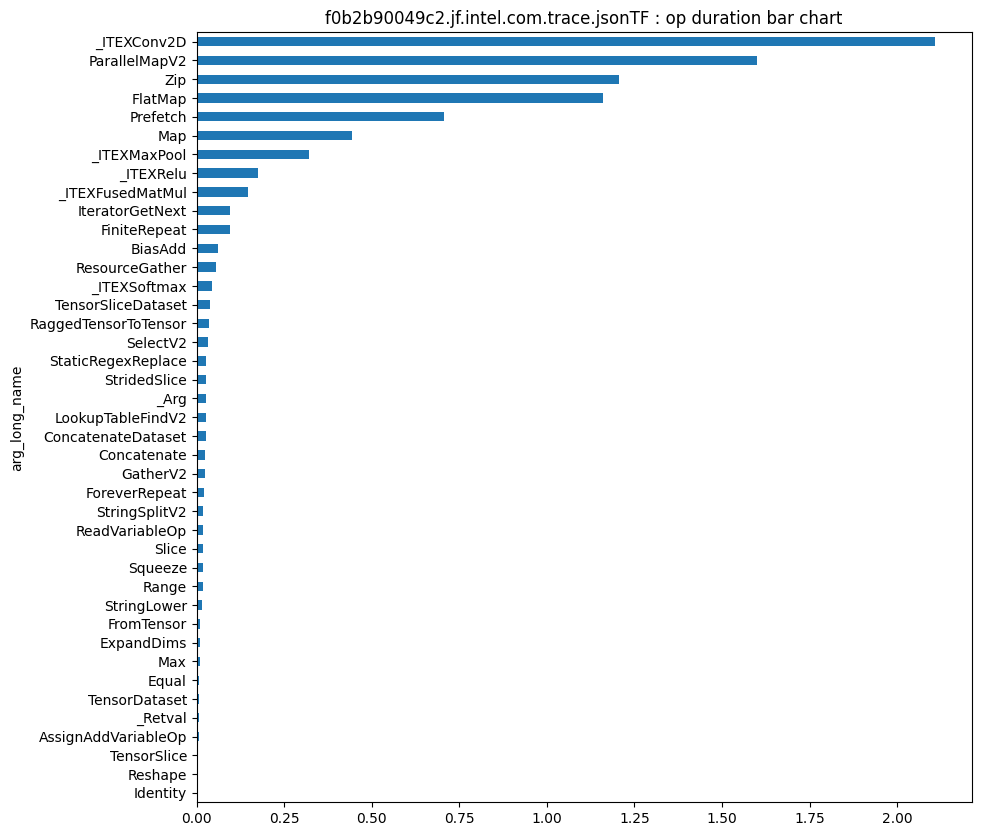

tf_ops_shape_dataframe.png


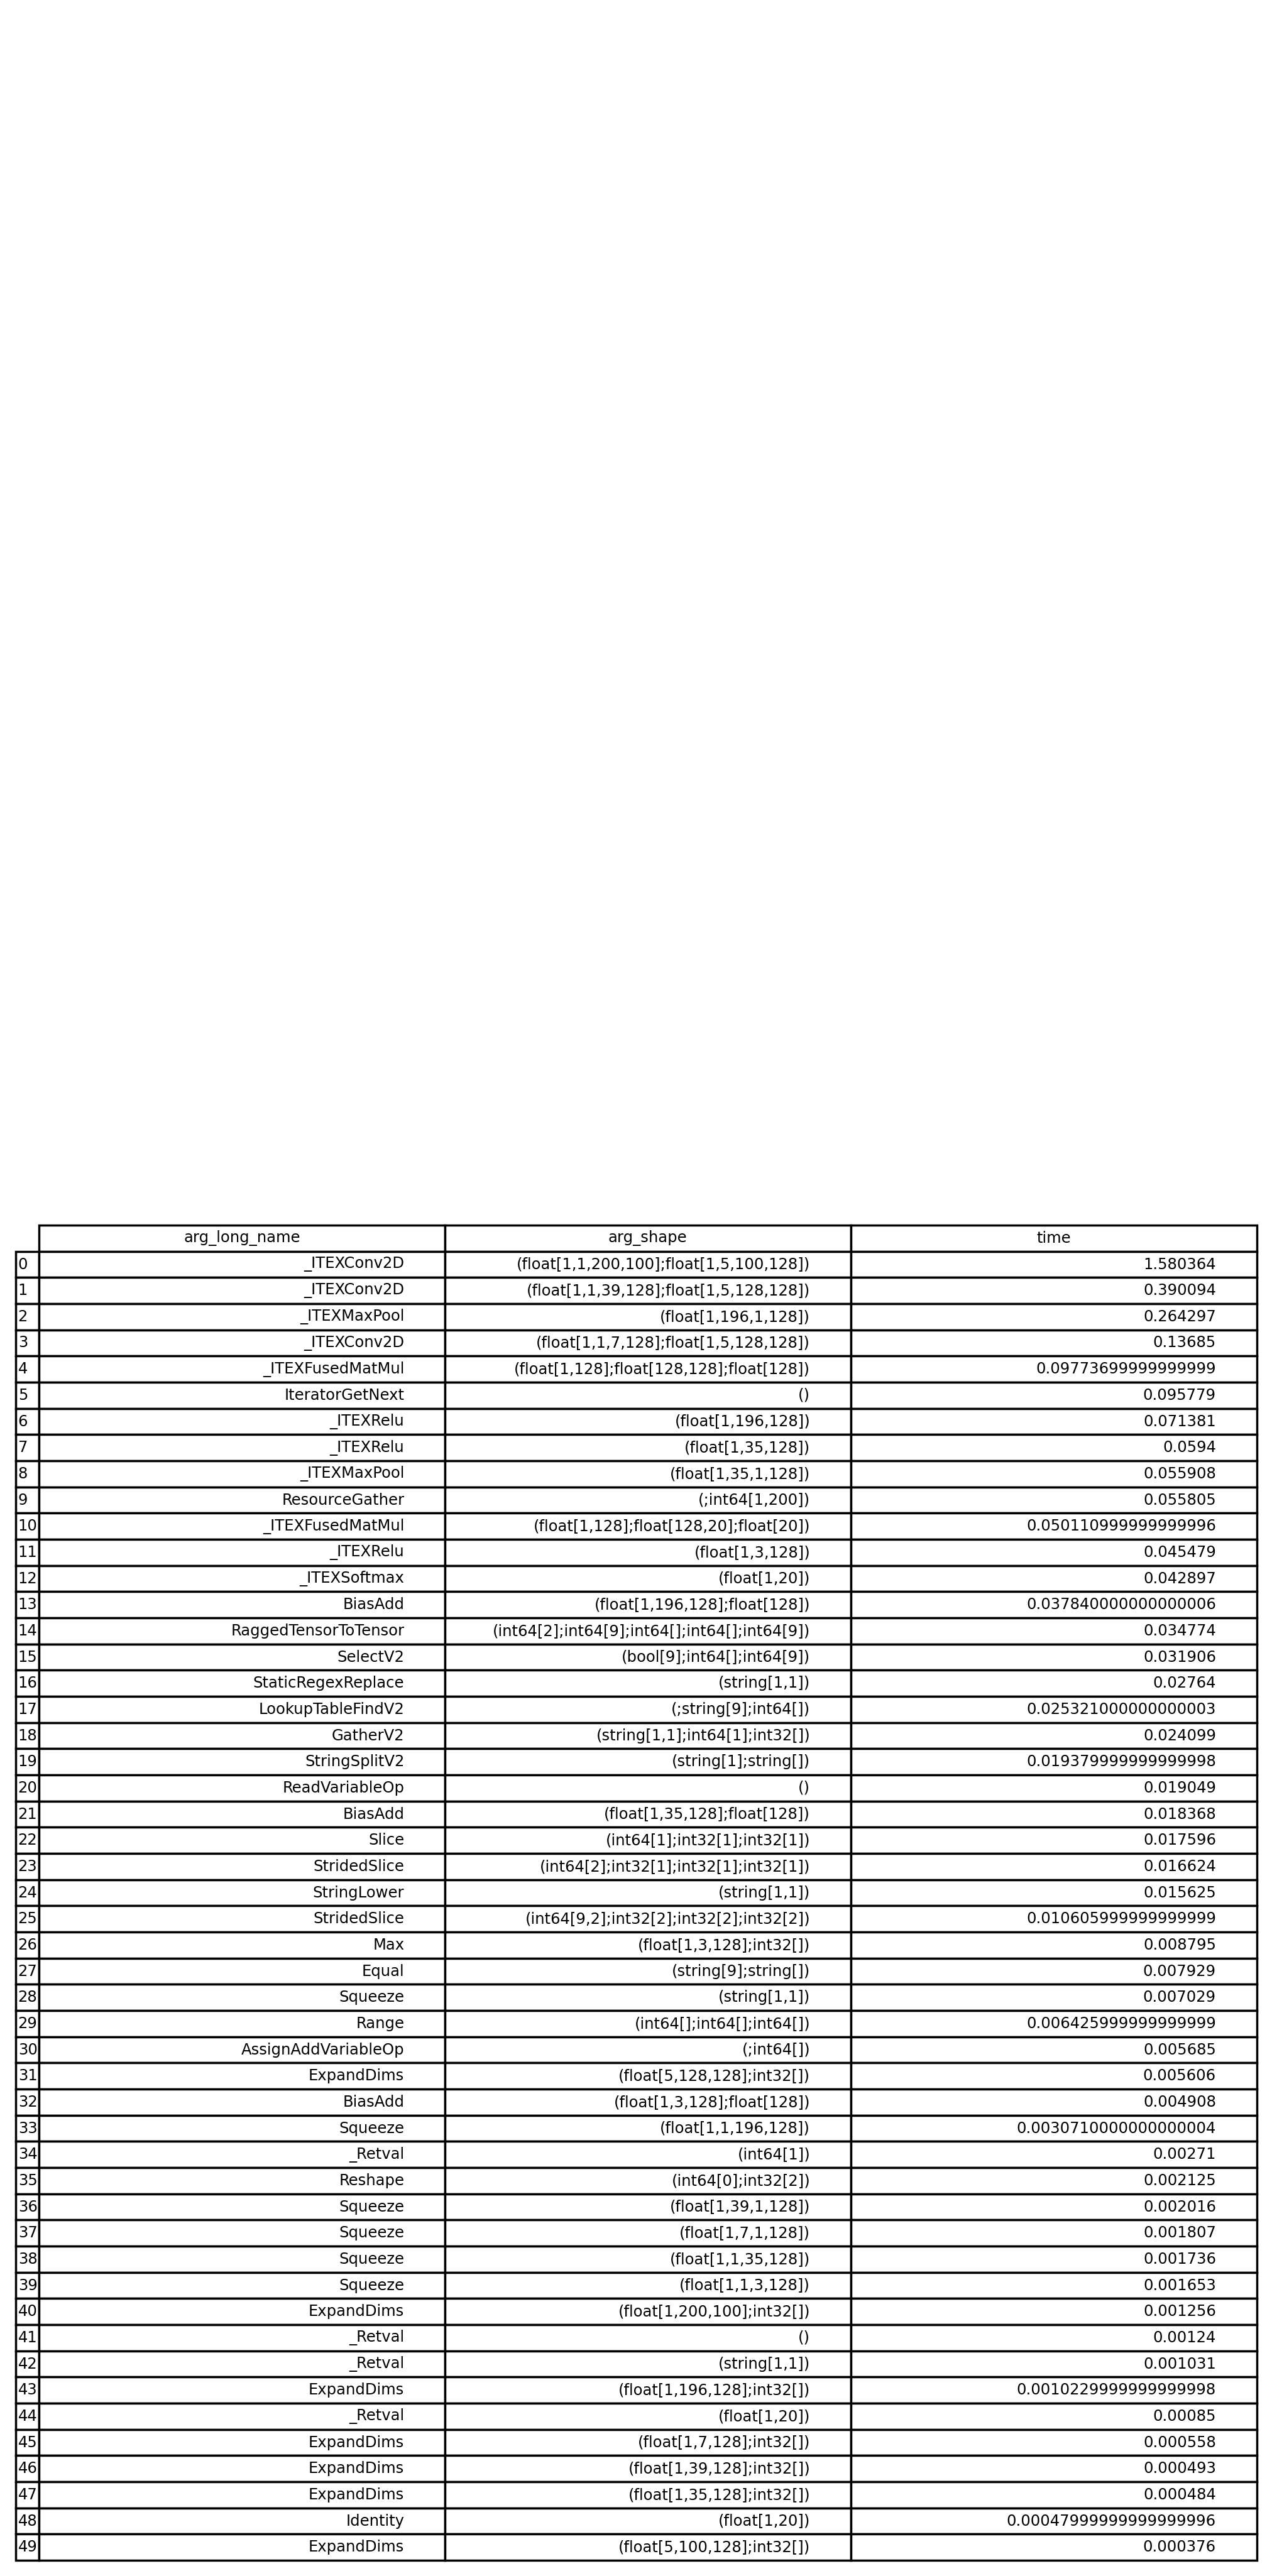

In [47]:
from IPython.display import Image
from IPython.display import display
for images in os.listdir(folder_dir):
    # check if the image ends with png
    if (images.endswith(".png")):
        print(images)
        x = Image(filename=folder_dir + images)
        display(x)

Let's remove the report folder now that we have displayed the report information.

In [48]:
!rm -rf report_*

The analyze script can also compare two json files from two different runs.   
We compare two json files. The stock_timeline was generated under stock tensorflow without oneDNN and mkl_timeline was generated under stock-tensorflow with oneDNN enabled.

In [49]:
!Analyze/analyze samples/stock_timeline_resnet50v1_5_fp32_infer_merged_runs.json samples/mkl_timeline_resnet50v1_5_fp32_infer_merged_runs.json

['Analyze/analyze', 'samples/stock_timeline_resnet50v1_5_fp32_infer_merged_runs.json', 'samples/mkl_timeline_resnet50v1_5_fp32_infer_merged_runs.json']
base_stock_timeline_resnet50v1_5_fp32_infer_merged_runs.csv
compare_mkl_timeline_resnet50v1_5_fp32_infer_merged_runs.csv
compare_mkl_timeline_resnet50v1_5_fp32_infer_merged_runs_mkl_percentage.csv
read into pandas : base_stock_timeline_resnet50v1_5_fp32_infer_merged_runs.csv
read into pandas : compare_mkl_timeline_resnet50v1_5_fp32_infer_merged_runs.csv
tags :  ['base', 'compare']
/home/kevinmj/oneAPI-samples/AI-and-Analytics/Features-and-Functionality/IntelTensorFlow_PerformanceAnalysis/Analyze/analyze_utils.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extra = extra.append(series, ignore_index=True)
/home/kevinmj/oneAPI-samples/AI-and-Analytics/Features-and-Functionality/IntelTensorFlow_PerformanceAnalysis/Analyze/analyze_utils.py:274: Fut

In [50]:
find_and_assign_report_folder()

report_2025-04-04_14-27


Please change folder_dir and put the report folder that you want to analyze.  
Overall, you should pick the latest report folder.  

In [51]:
folder_dir=folder_dir+"/"

There are report.html file which shows all the analysis diagrams.  
We show all the analysis diagrams below, and your could refer to Analyze/README.md file for more details of those analysis diagrams. 

tf_ops_2_dataframe.png


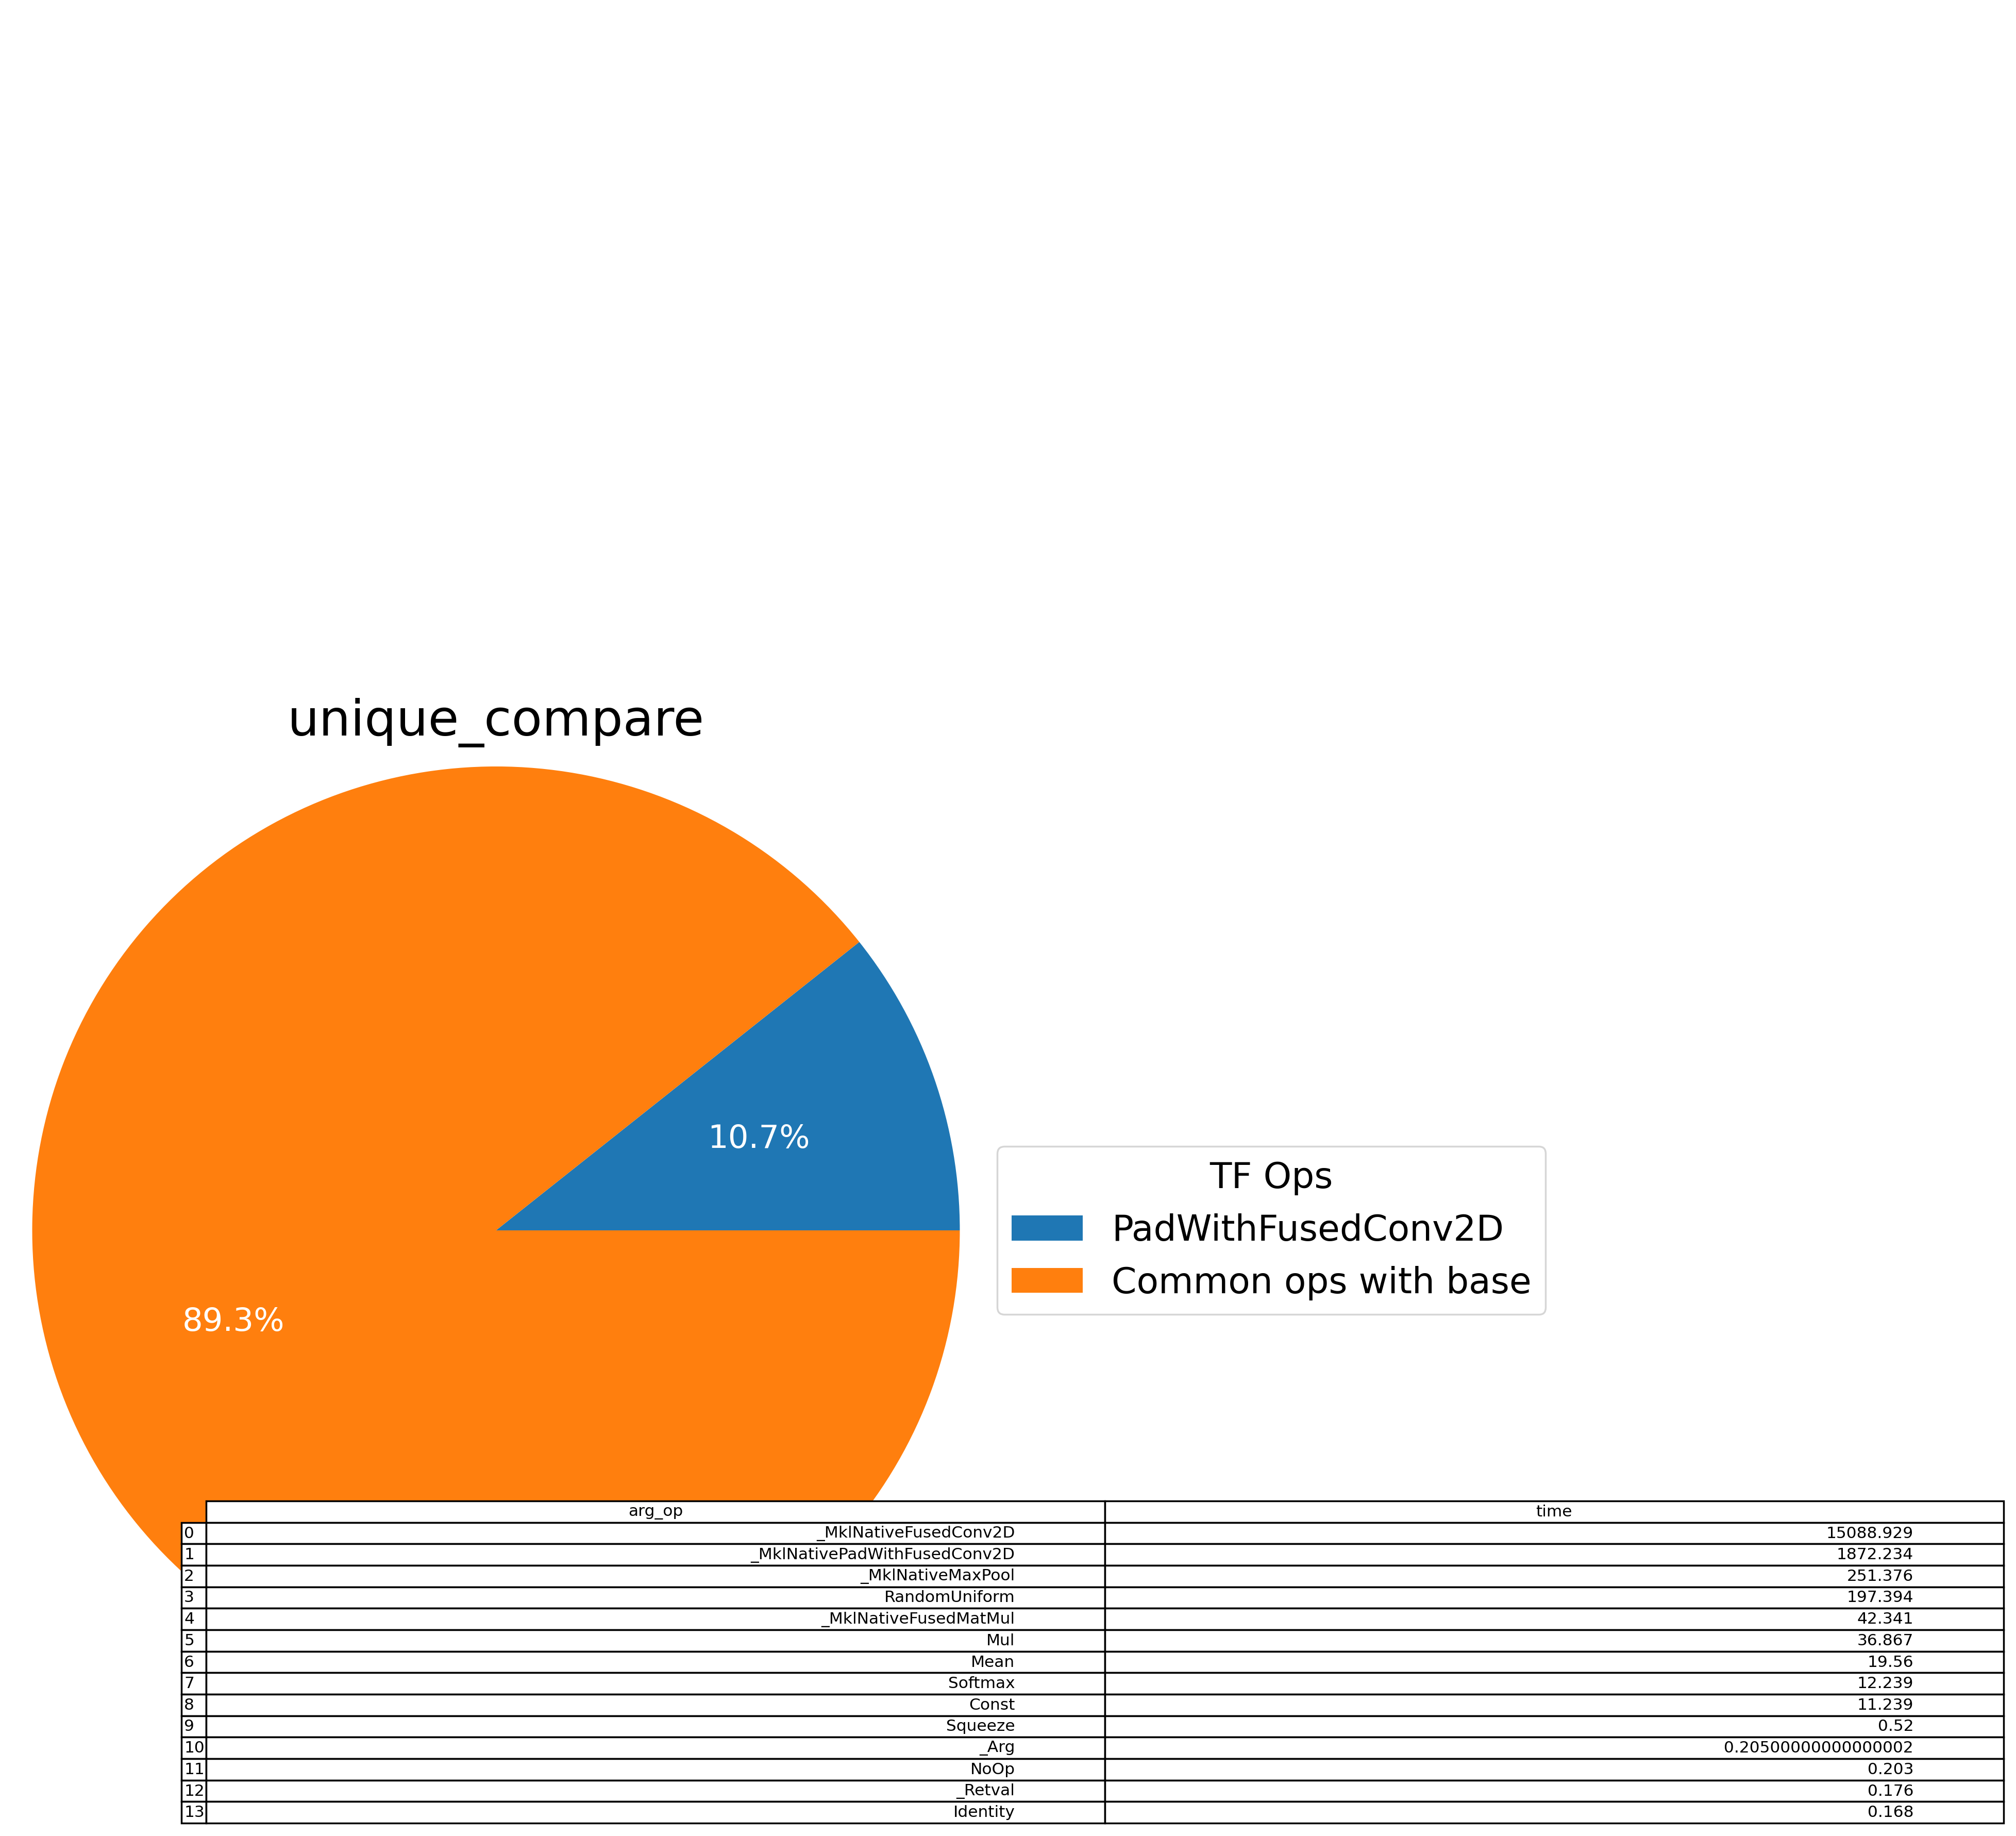

mkl_percentage_tf_op_duration_pie.png


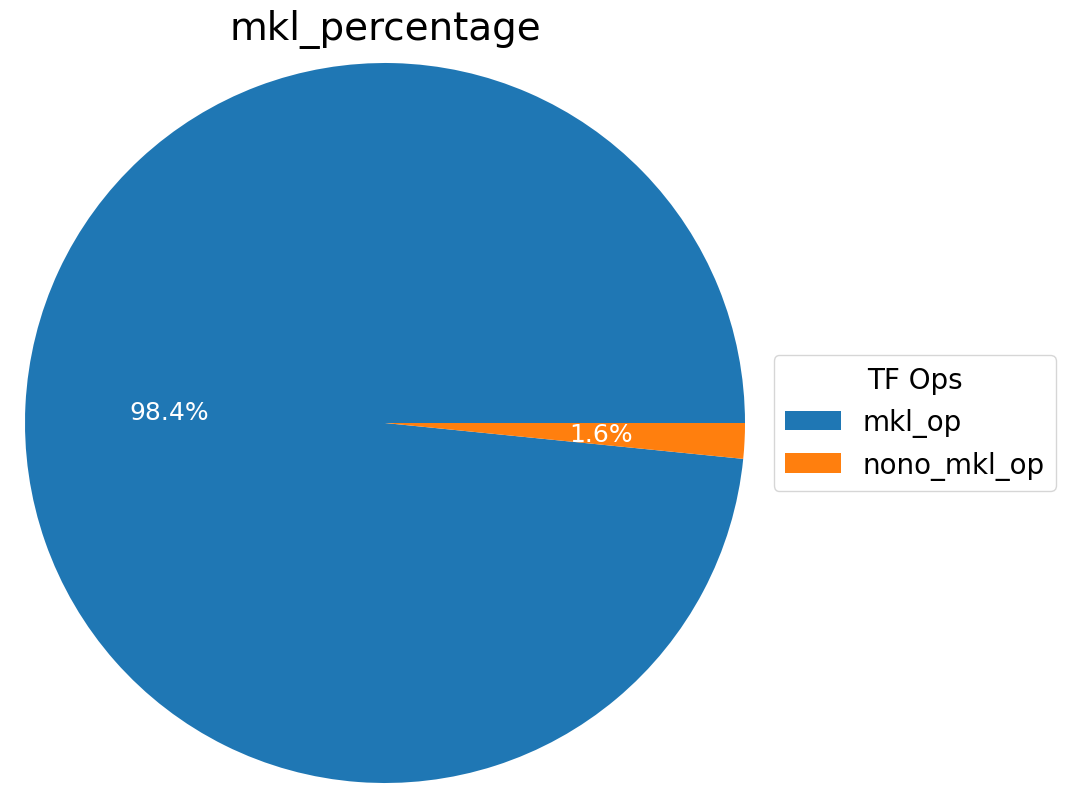

unique_base_tf_op_duration_pie.png


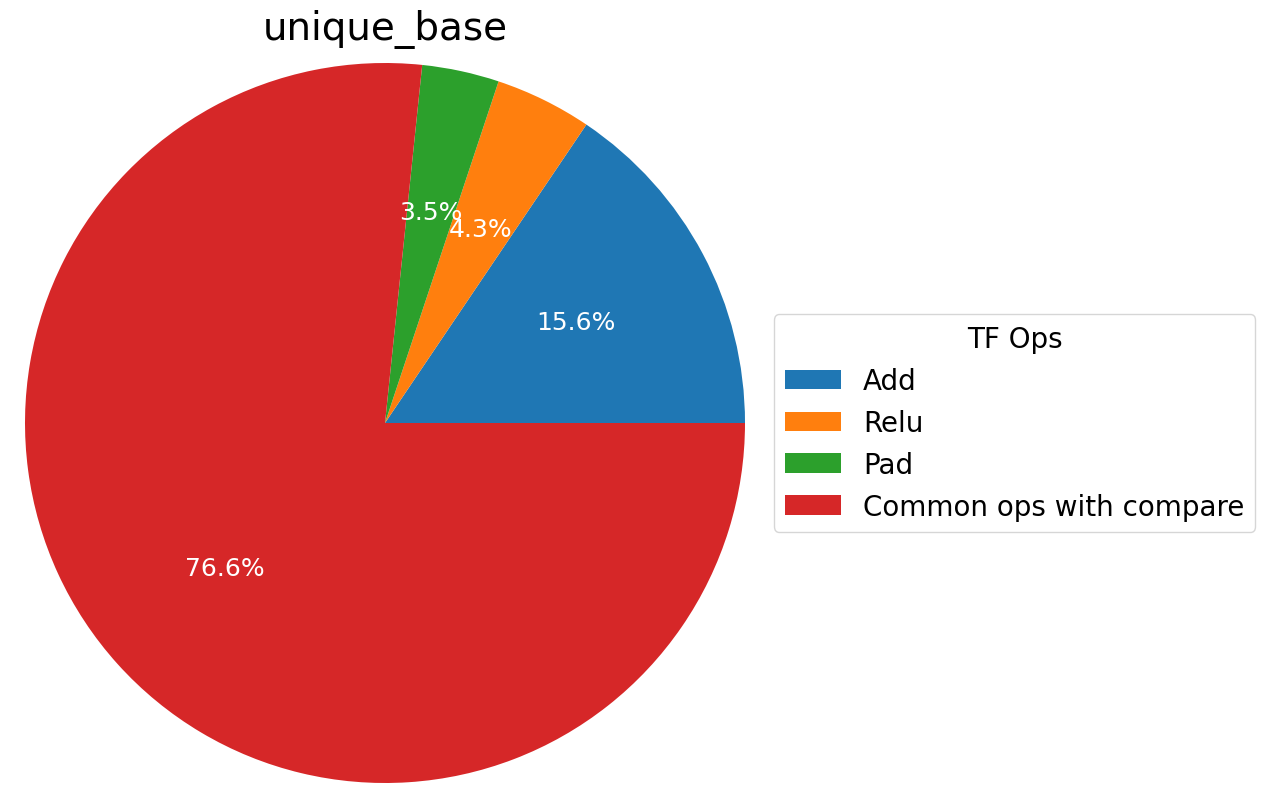

tf_ops_1_dataframe.png


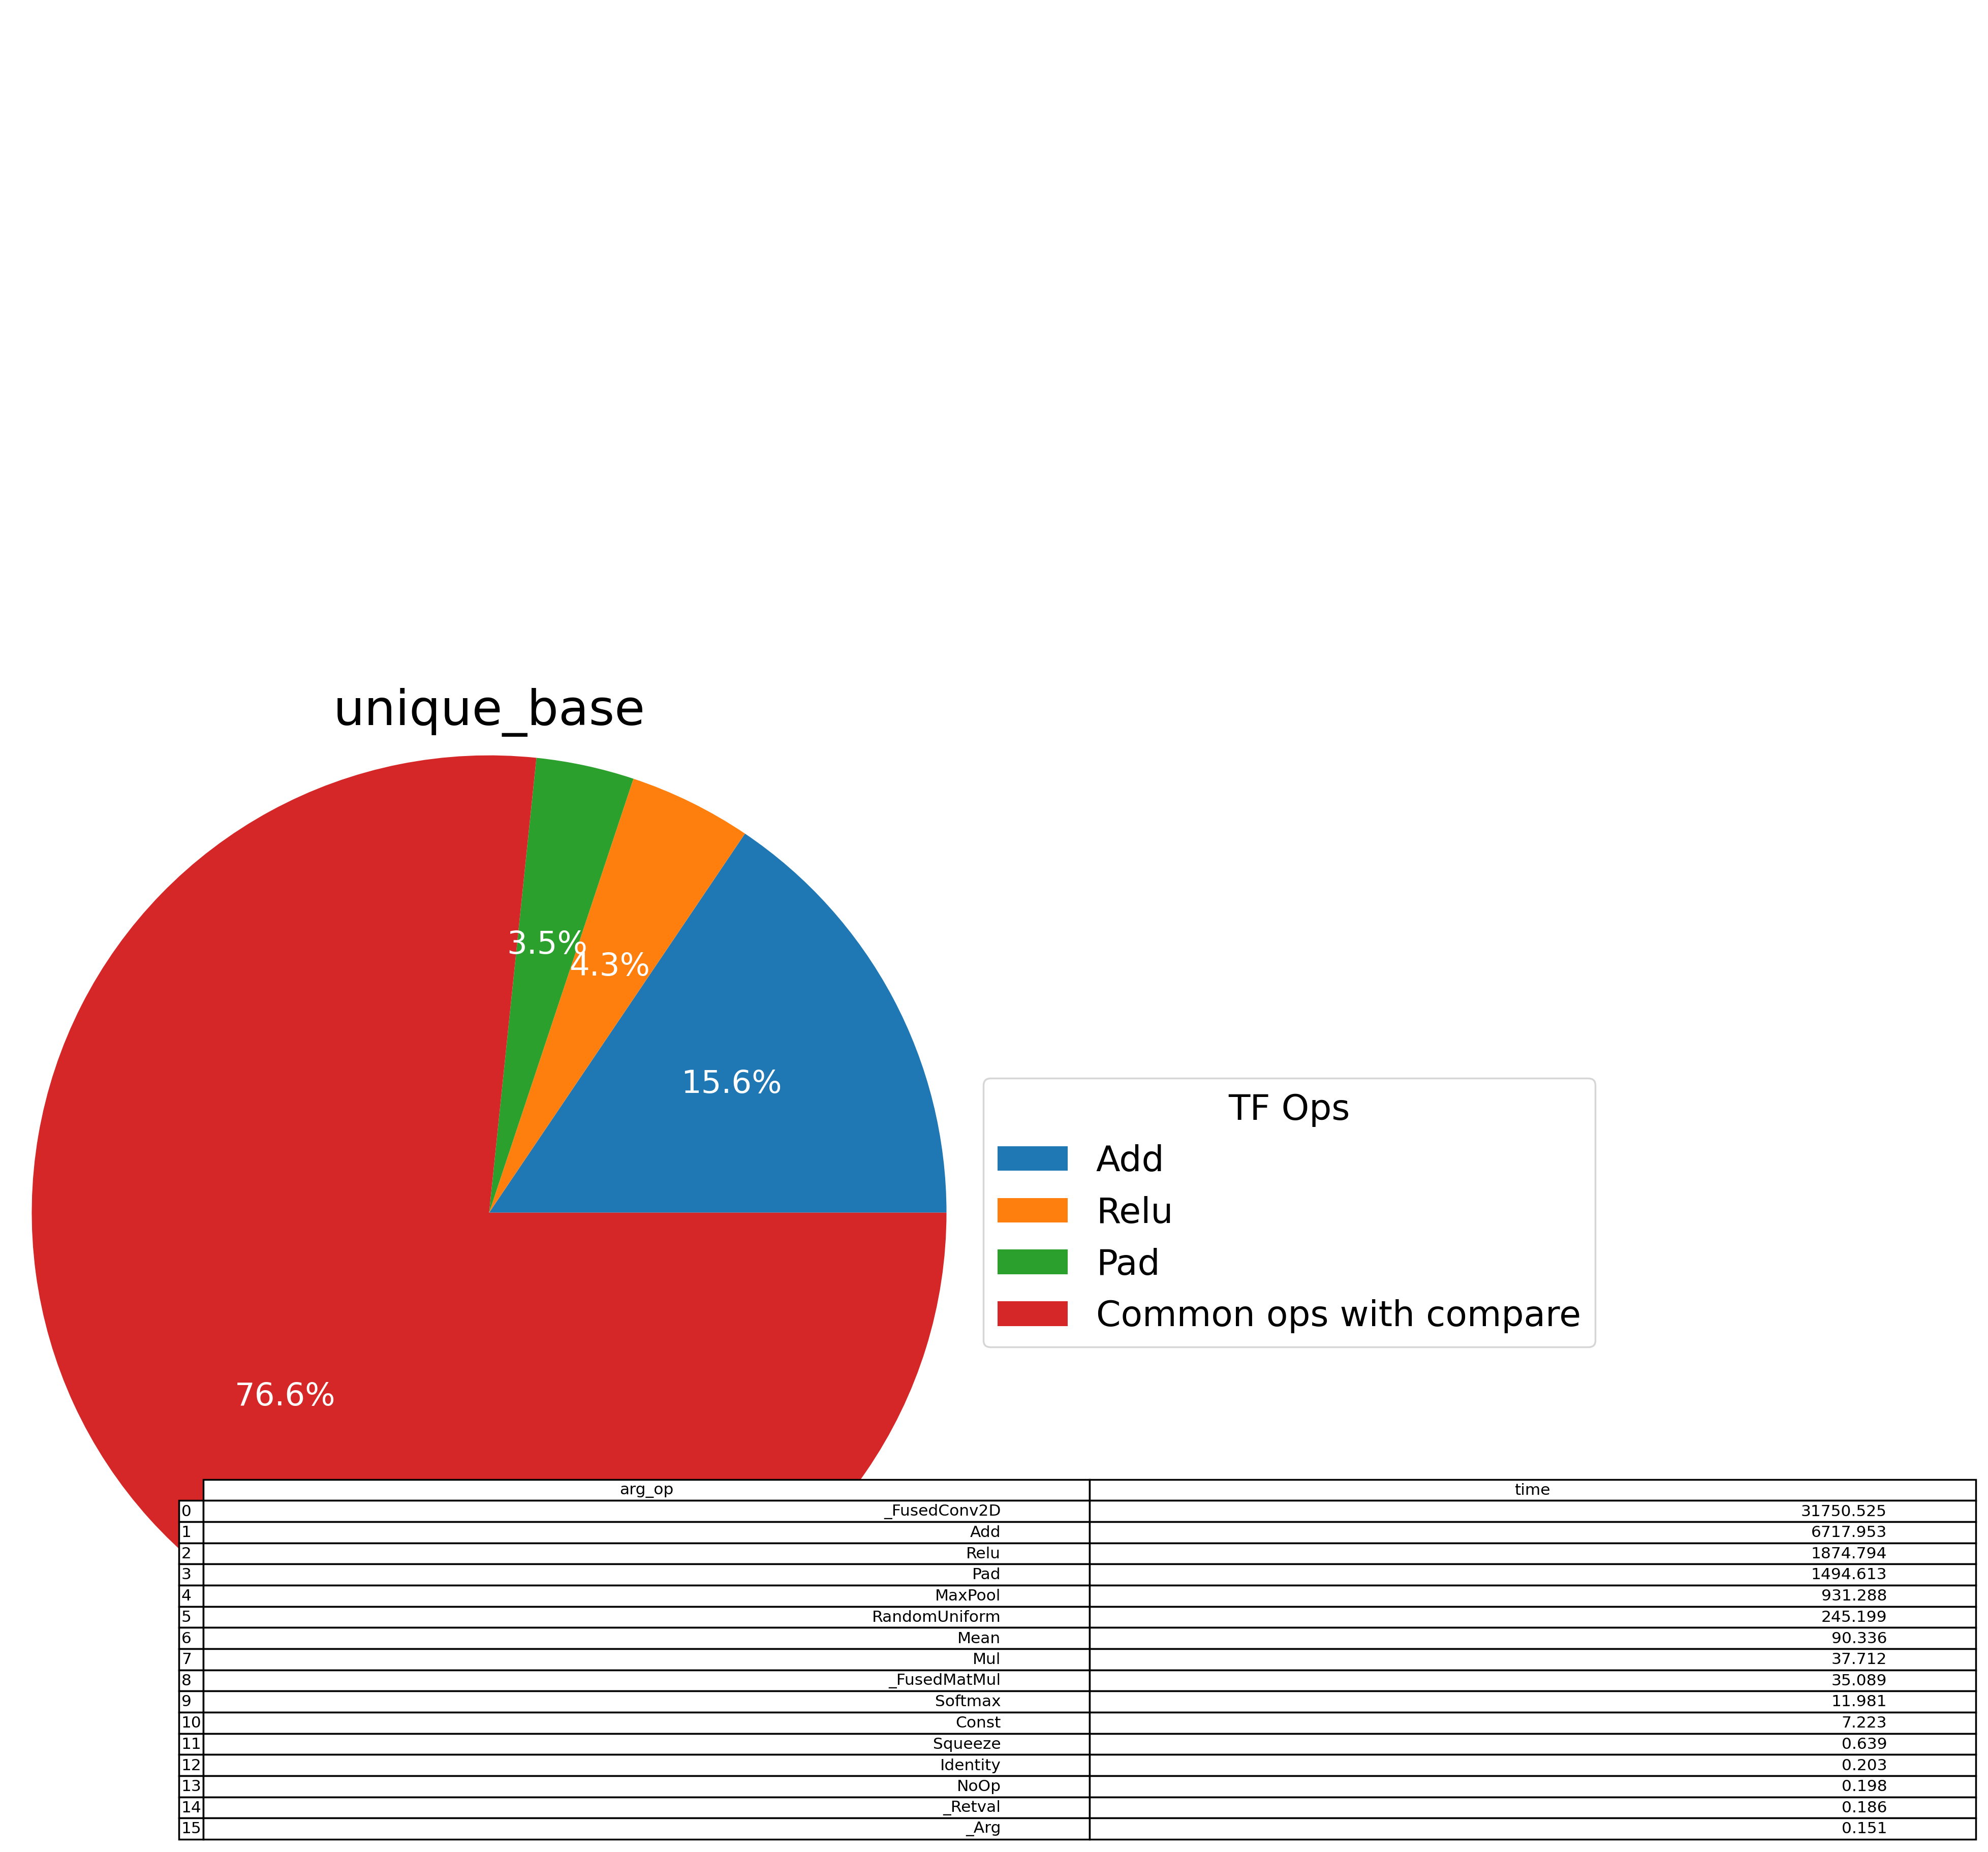

compared_tf_op_duration_bar.png


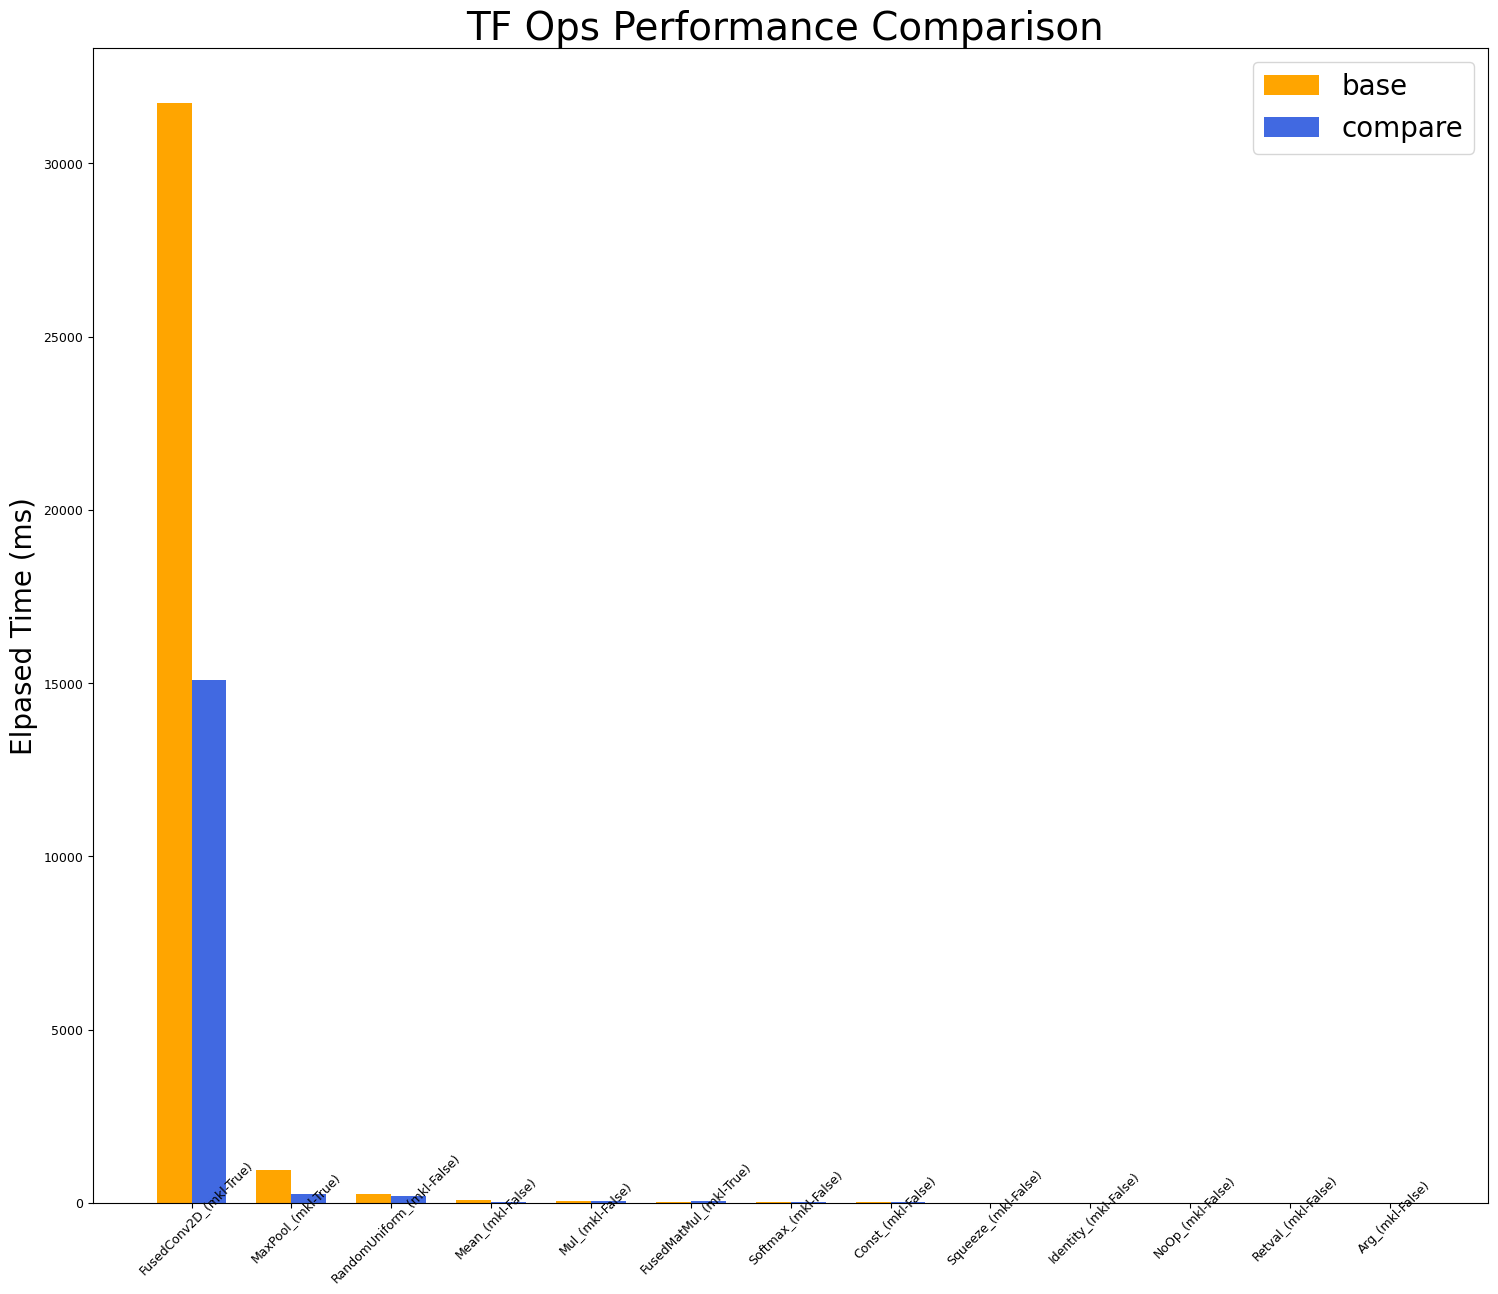

compare_tf_op_duration_pie.png


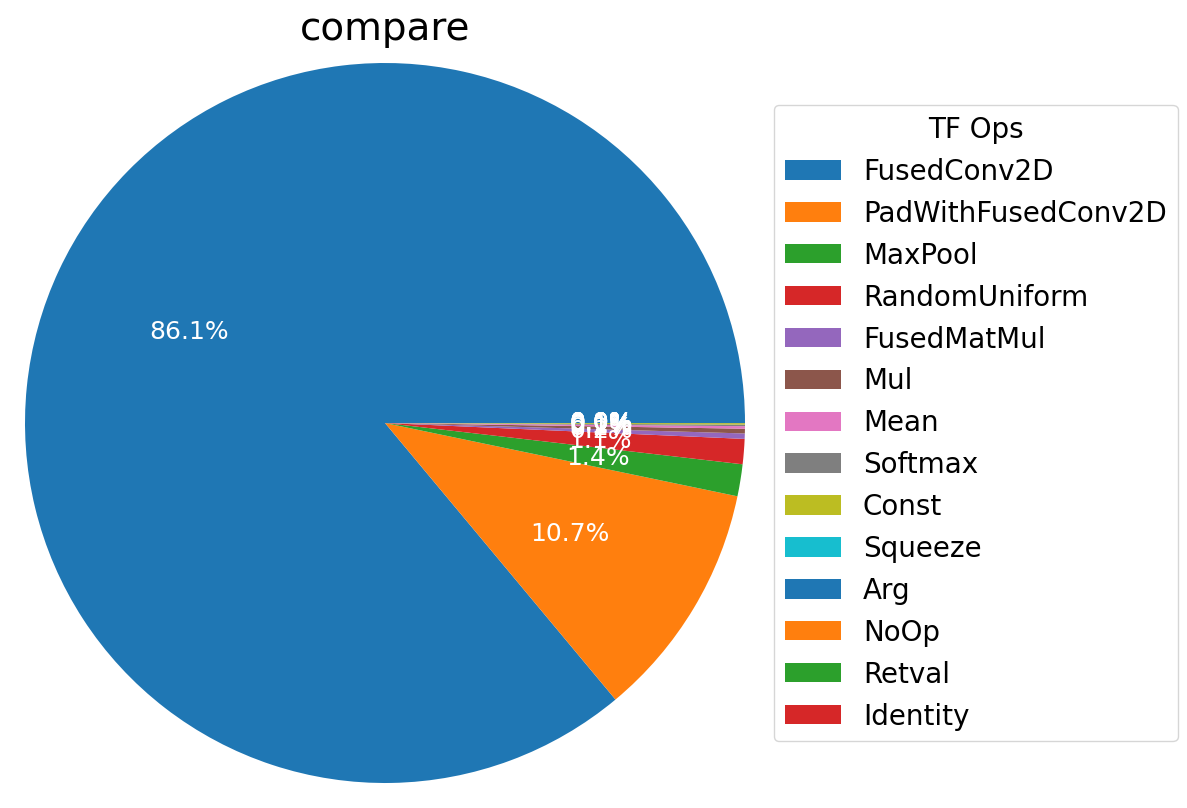

unique_compare_tf_op_duration_pie.png


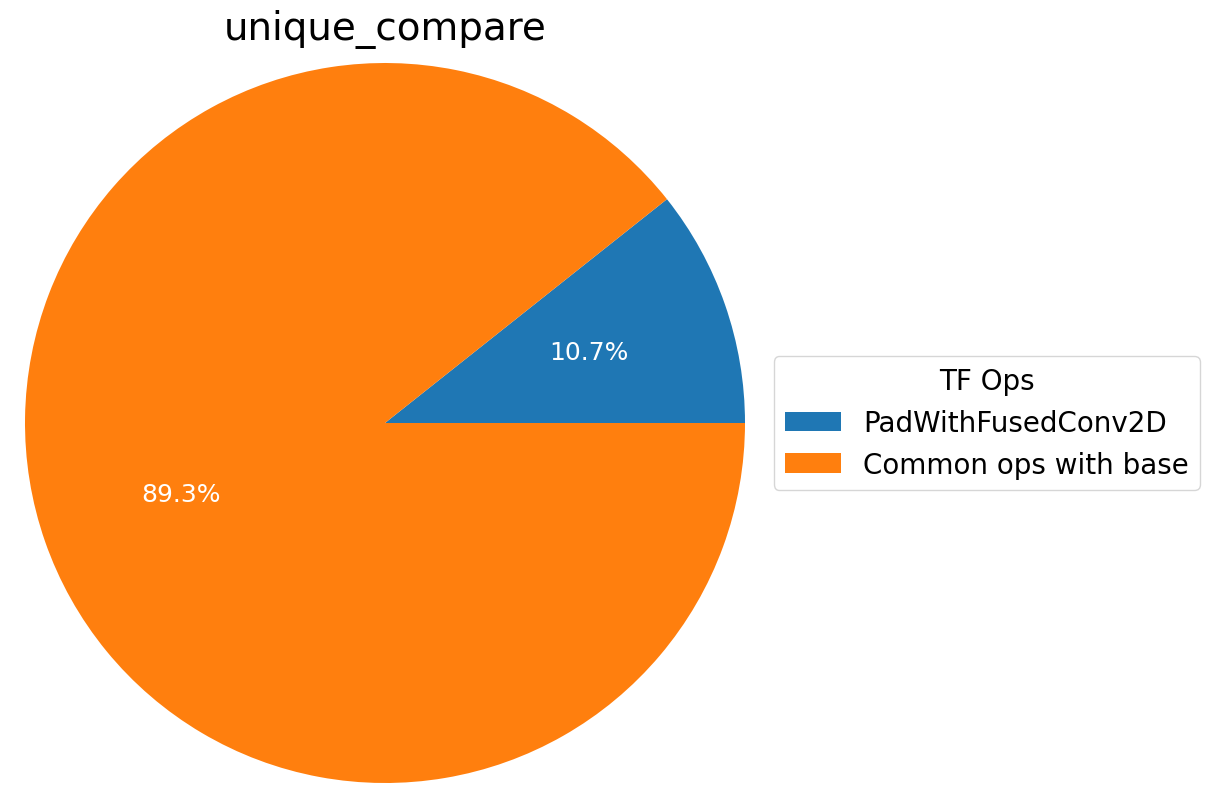

compared_tf_op_duration_ratio_bar.png


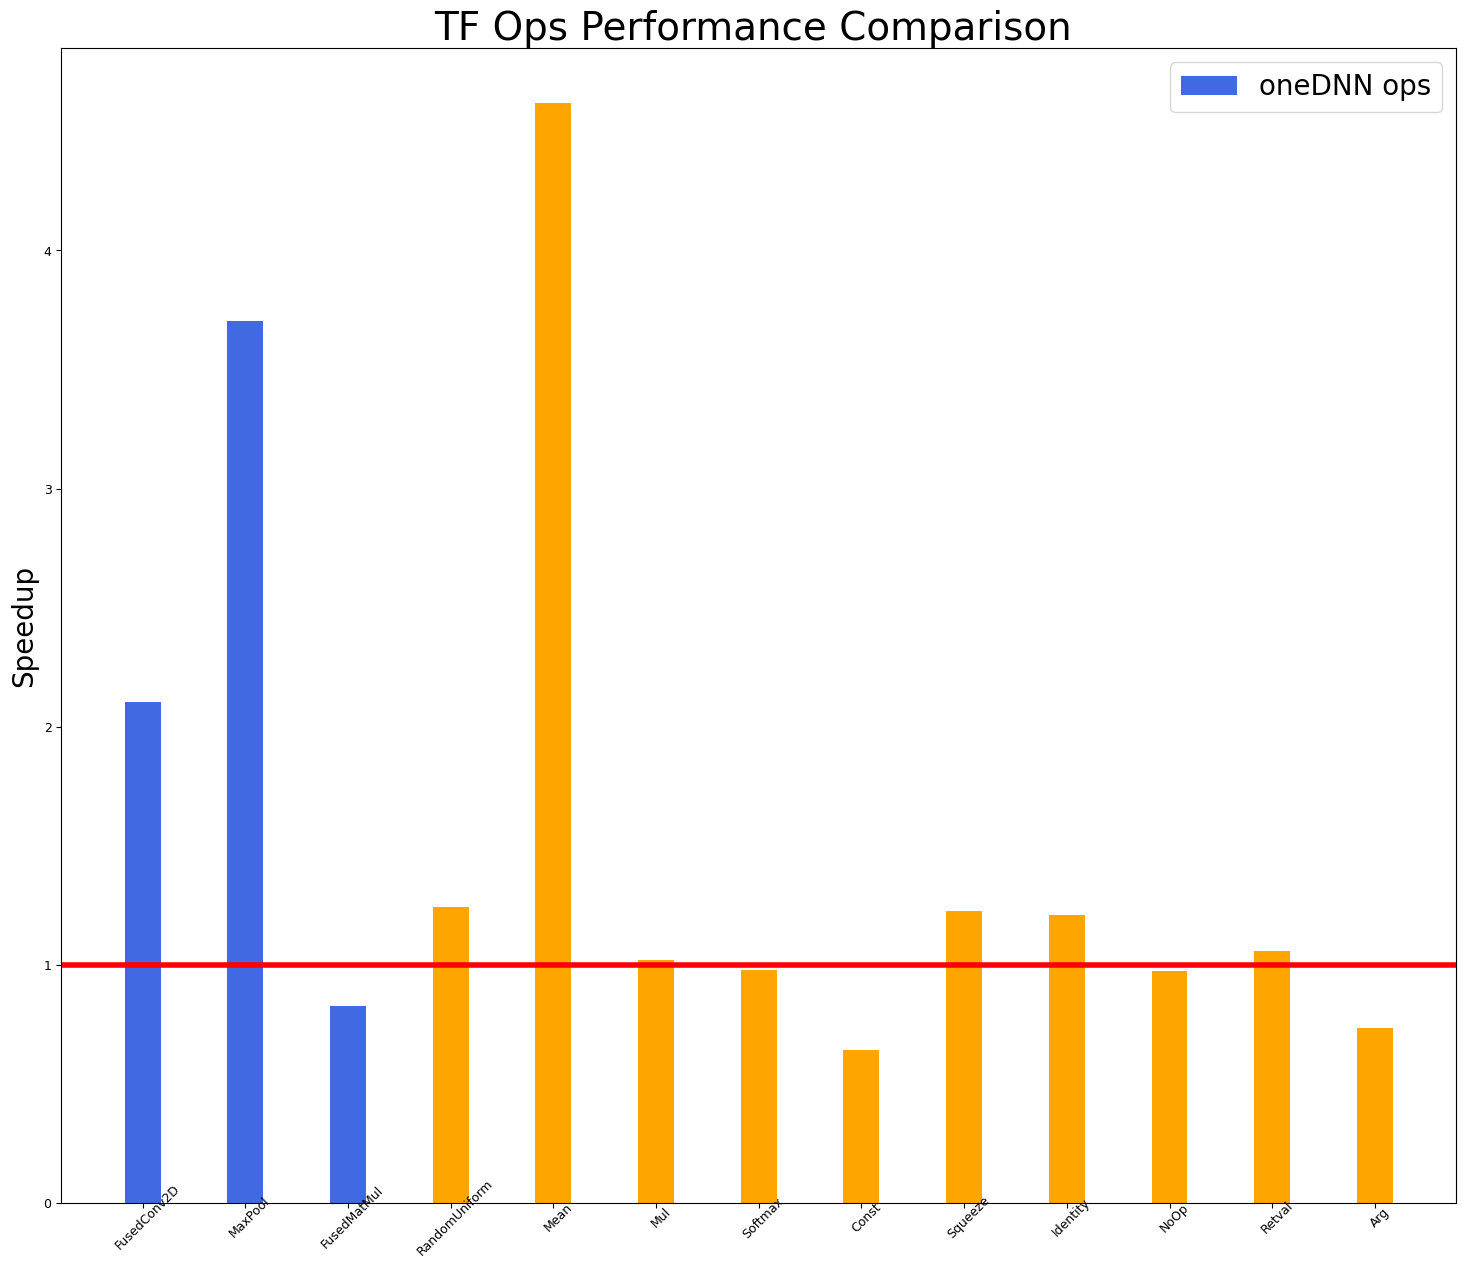

base_tf_op_duration_pie.png


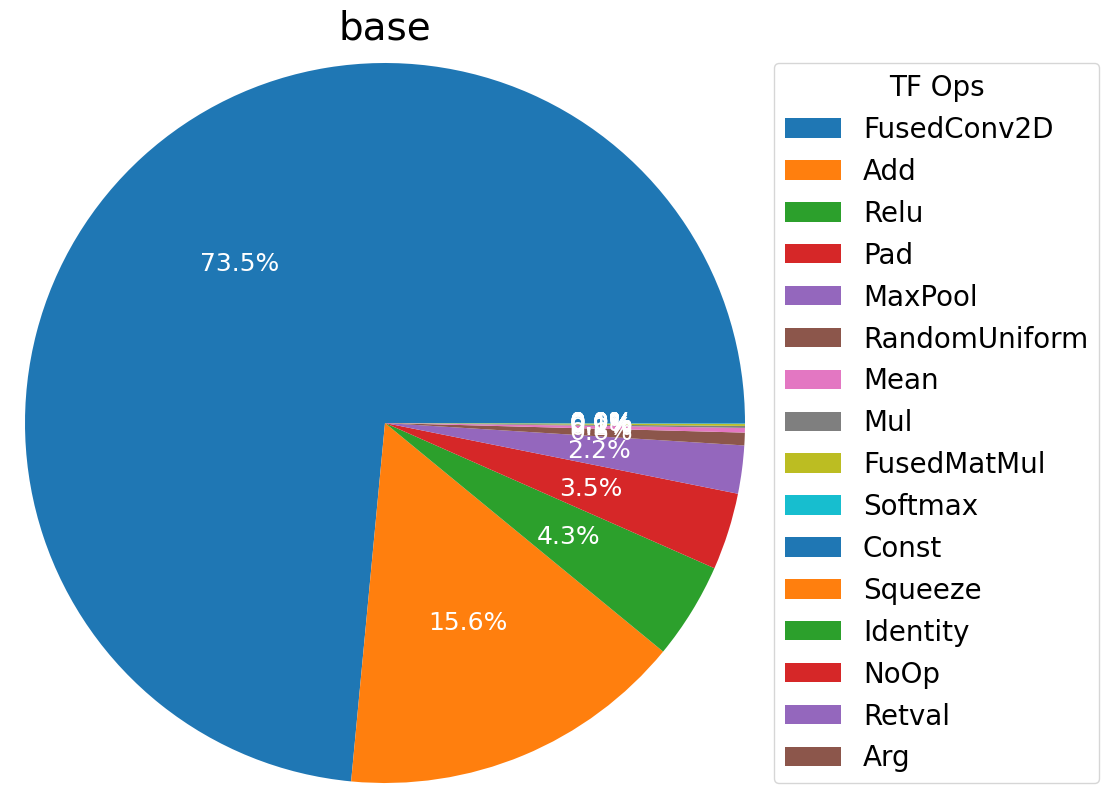

common_ops_dataframe.png


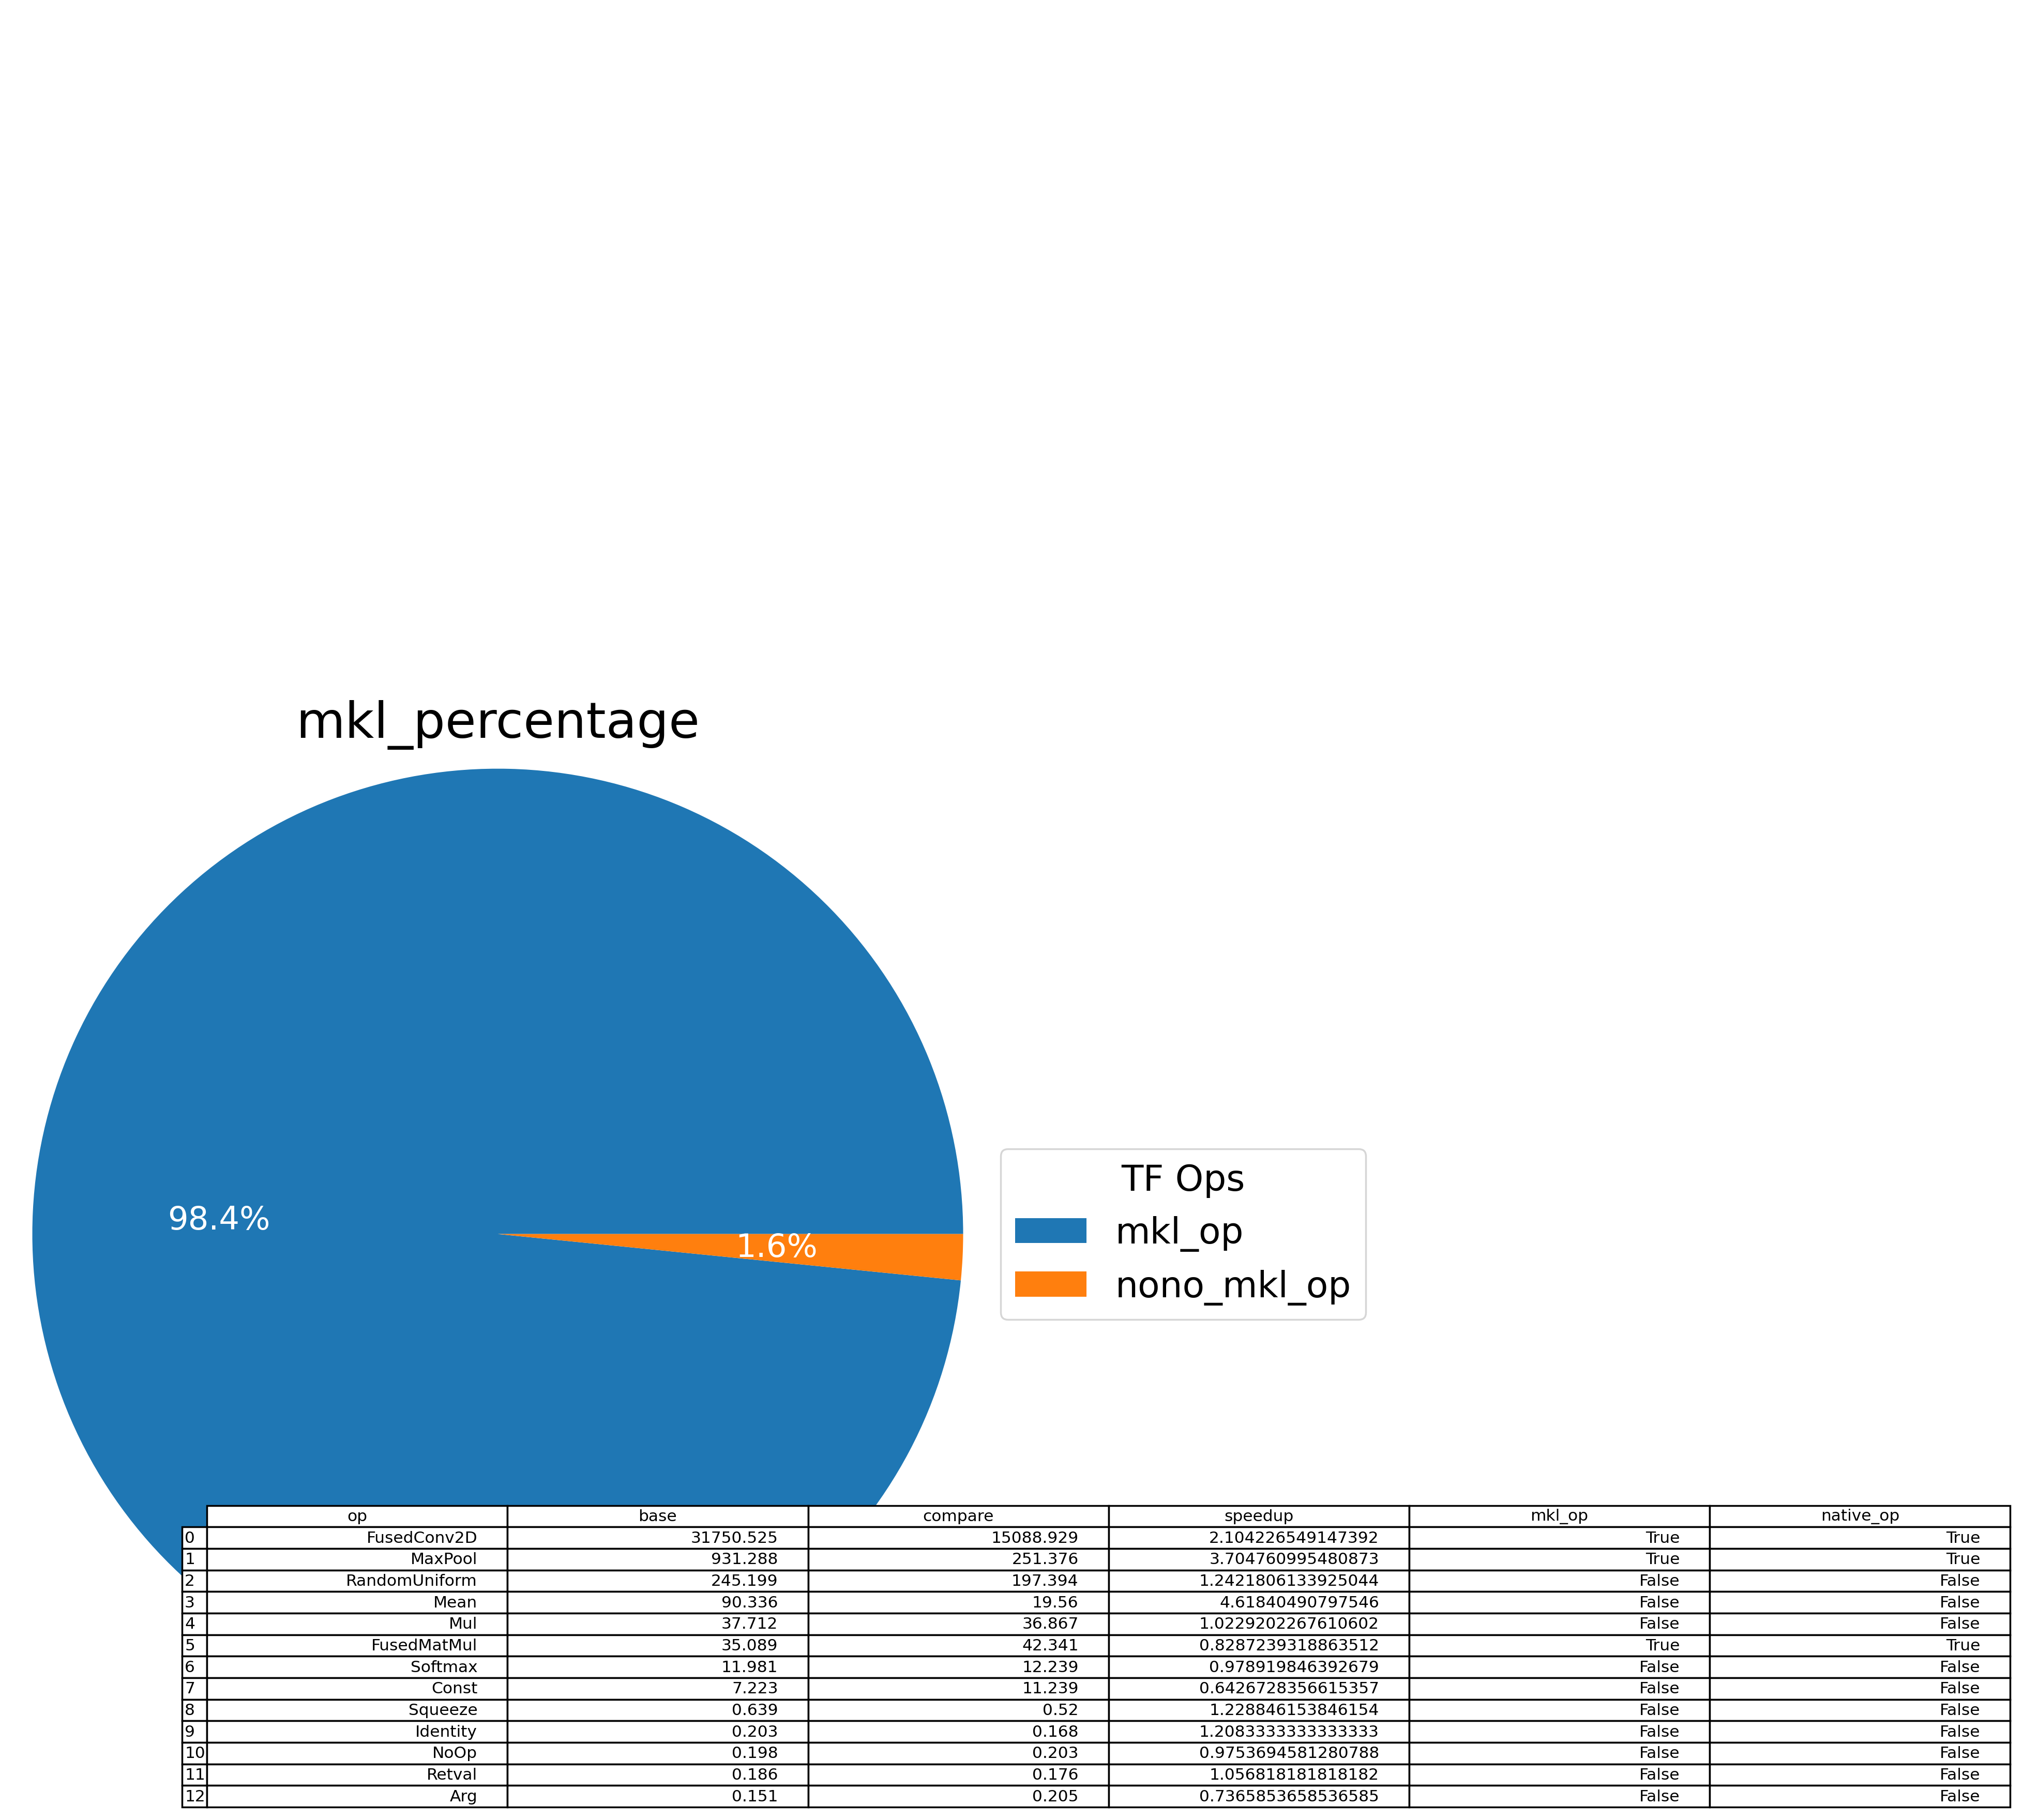

In [52]:
from IPython.display import Image
from IPython.display import display

for images in os.listdir(folder_dir):
    # check if the image ends with png
    if (images.endswith(".png")):
        print(images)
        x = Image(filename=folder_dir + images)
        display(x)


The output(both stdout and stderr) is displayed on the command line console

Let's agains remove the report folder.

In [53]:
!rm -rf report_*

In [43]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
